In [105]:
from scipy import stats
import numpy as np

from dismal.likelihood_matrix import LikelihoodMatrix
from dismal.s_matrix import SMatrix

import pandas as pd

In [14]:
def composite_likelihood_gim(param_vals, S):
    params = {"theta0": param_vals[0],
              "theta1": param_vals[1],
              "theta2": param_vals[2],
              "theta1_prime": param_vals[3],
              "theta2_prime": param_vals[4],
              "t1": param_vals[5],
              "v": param_vals[6],
              "M1_star": param_vals[7],
              "M2_star": param_vals[8],
              "M1_prime_star": param_vals[9],
              "M2_prime_star": param_vals[10]}
    likelihood_matrix = LikelihoodMatrix(params, S)
    negll = np.sum(S * likelihood_matrix.matrix)

    return negll

In [ ]:
2.38 * posterior

In [121]:
def metropolis_hastings(S, initial_values, gamma_priors, samples=10000, burnin=1000, init_proposal_width=0.5, verbose=True):
    """Full GIM model only at this stage"""

    current_values = initial_values
    posterior = [current_values]
    likelihoods = []

    n_iter = burnin + samples

    proposal_width = [init_proposal_width] * len(current_values)

    for iter in range(n_iter):

        proposed_values = [stats.norm.rvs(current_values[i], proposal_width[i]) for i in range(len(current_values))]
        current_likelihood = composite_likelihood_gim(current_values, S)

        try:
            proposed_likelihood = composite_likelihood_gim(proposed_values, S)

            current_priors = np.array([stats.gamma.pdf(x=current_values[i], a=gamma_priors[i][0], scale=gamma_priors[i][1])
                           for i in range(len(current_values))])
            proposed_priors = np.array([stats.gamma.pdf(x=proposed_values[i], a=gamma_priors[i][0], scale=gamma_priors[i][1])
                           for i in range(len(proposed_values))])

 
            current_prob = np.prod(current_likelihood * current_priors)

            proposed_prob = np.prod(proposed_likelihood * proposed_priors)


            accept_prob = proposed_prob/current_prob
            accept = np.random.rand() < accept_prob

            if accept:
                current_values = proposed_values

        except Exception: # likelihood calculation fails for some parameters
            current_values = current_values
        
        if n_iter > burnin:
            posterior.append(current_values)

            if verbose:
                if (iter-burnin)%100 == 0:
                    print(f"Iteration {iter-burnin}: {current_values}")

        proposal_width = 2.4 * np.array(current_values) / len(current_values)
                  
    return np.array(posterior)

        



In [122]:
# Read in some data for testing
S = SMatrix().from_rgim_simulation(
        paths = [f"~/Dropbox/DISMaL_chapter/simulations/r_simulations_parameter_bias/simulation_data/scenario1_x{i}_1.txt" for i in [1,2,3]]
    )


In [123]:
 mcmc_res = metropolis_hastings(S=S,
                    initial_values=[5, 5, 5, 5, 5, 5, 5, 0.3, 0.3, 0.3, 0.3],
                    gamma_priors=[(5,1)]*7 + [(0.5, 1)]*4,
                    samples=10000, burnin=1000)

Iteration -1000: [5, 5, 5, 5, 5, 5, 5, 0.3, 0.3, 0.3, 0.3]
Iteration -900: [4.1836051972692765, 6.158529962040704, 1.353170715718482, 4.883277479154653, 2.2175566016571255, 5.022321857833212, 2.7883747619283272, 0.07141704210286055, 1.6966448042469022, 0.0019228313054032427, 0.009875740335030869]
Iteration -800: [1.6573377115523333, 3.2667331544167086, 0.5341762948252848, 1.6250171602749255, 5.390536268024266, 0.5816842595220265, 3.1086635842160697, 0.1001835592349489, 0.04290432091033561, 0.002843639427488901, 0.002099495802088504]
Iteration -700: [1.840206446270638, 4.181399845161318, 1.390486945806306, 2.61156986855609, 3.074060872431583, 1.7945578921241432, 7.319236881734325, 0.011581859193143888, 0.018205293610862625, 0.0028408977333544256, 0.00164546565786689]
Iteration -600: [3.519922269242177, 2.8265382554727485, 8.059229800360043, 5.580290165454474, 1.1063014965890112, 4.46818828321521, 4.650121597955556, 0.00046557084948002994, 0.02672437186584687, 0.0010087604647035055, 2.58

In [124]:
res_df = pd.DataFrame(mcmc_res[1000:])
res_df.columns = ["theta0", "theta1", "theta2", "theta1_prime", "theta2_prime",
                  "t1", "v", "M1_star", "M2_star", "M1_prime_star", "M2_prime_star"]
res_df

,theta0,theta1,theta2,theta1_prime,theta2_prime,t1,v,M1_star,M2_star,M1_prime_star,M2_prime_star
0,0.300126,3.485123,1.451724,3.844134,5.845681,0.341769,0.738777,1.446999e-11,1.219891e-09,9.012411e-11,1.341659e-11
1,0.297493,3.727023,1.440154,4.203422,5.952671,0.414879,0.693742,1.838487e-11,9.038228e-10,9.703583e-11,8.101887e-12
2,0.297493,3.727023,1.440154,4.203422,5.952671,0.414879,0.693742,1.838487e-11,9.038228e-10,9.703583e-11,8.101887e-12
3,0.297493,3.727023,1.440154,4.203422,5.952671,0.414879,0.693742,1.838487e-11,9.038228e-10,9.703583e-11,8.101887e-12
4,0.297493,3.727023,1.440154,4.203422,5.952671,0.414879,0.693742,1.838487e-11,9.038228e-10,9.703583e-11,8.101887e-12
...,...,...,...,...,...,...,...,...,...,...,...
9996,4.557653,2.599523,1.657172,2.384984,0.067103,5.272611,9.409433,2.153864e-112,1.872008e-103,4.672433e-113,2.654232e-121
9997,3.267949,2.268197,1.473038,3.498386,0.083780,4.345241,7.973419,2.833951e-112,2.343570e-103,4.398345e-113,2.583333e-121
9998,3.460941,2.197845,1.827002,3.270819,0.098997,3.268652,8.185518,2.678662e-112,1.910851e-103,3.757589e-113,2.226832e-121
9999,3.460941,2.197845,1.827002,3.270819,0.098997,3.268652,8.185518,2.678662e-112,1.910851e-103,3.757589e-113,2.226832e-121


<Axes: >

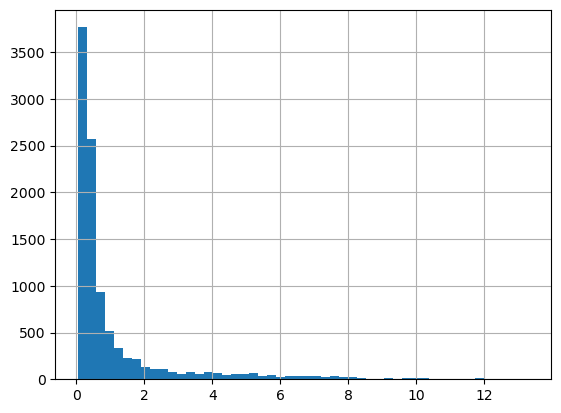

In [127]:
res_df["theta0"].hist(bins=50)

In [128]:
res_df["theta0"].mean()

1.0651492511091678